In [1]:
from pynq import Overlay
from time import sleep
import numpy as np
from matplotlib import pyplot as plt
from os import path
import pandas as pd
from datetime import datetime, timedelta
from pytz import timezone
%matplotlib inline

In [2]:
class TestChip(Overlay):
    """TestChip class is the main driver
    class for interacting with our FPGA bitstream
    Coded by: Uncle Arash
    Version: 0.0
    """
    def __init__(self, ol_path, **kwargs):
        super().__init__(ol_path)
        self.heater_base_address = 0x00000000
        self.RO_base_address = 0x00000000
        self.BTI_base_write_address = 0x00000000
        self.BTI_base_read_address = 0x00000004
        self.temp_sensor_address = 0x200
        self.counter_address_increament = 0x04
        self.num_oscillators = 31
        self.num_BTI = 31
        self.intensity_dict = {i: int(sum(
                                          [2**j for j in range(i)])
                                      ) for i in range(1, 33)
                               }
        self.intensity_dict[0] = 0
        self.sensor_dict = {i: 2**i for i in range(32)}
        for key, value in kwargs.items():
            if "heater_base_address" in key:
                self.heater_base_address = value
            if "counter_base_address" in key:
                self.counter_base_address = value
            if "num_oscillators" in key:
                self.num_oscillators = value
            if "counter_address_increament" in key:
                self.counter_address_increament = value
            if "temp_sensor_address" in key:
                self.temp_sensor_address = value
        self._a = 4.07548611   # 5
        self._b = 0.50103761   # 50
        self.temp_ctrl_sensitivity = 2
        self.temp_ctrl_intensity = 0

    def XADC_temp(self):
        return ((self.Temp_sensor.read(self.temp_sensor_address
                                       ) >> 4) * 503.975/4096 - 273.15)

    def freq2temp(self, Δf):
        """The values of a and b are for 5 stage ROs in ZYNQ 7000"""
        return Δf * self._a + self._b

    def read_RO(self, RO_list):
        """Reads the frequency of selected ROs
        Parameters:
        RO_list (list of int): list of ROs whose values we read

        Returns: freq_list (nparray)
        """
        len_ro = len(RO_list)
        freq_list = np.zeros((len_ro))
        for i in range(len_ro):
            assert RO_list[i] <= self.num_oscillators
            freq_list[i] = self.RO0.read(
                self.RO_base_address +
                RO_list[i] * self.counter_address_increament
            )/1000
        return freq_list

    def read_multi_RO(self, RO_dict):
        """Reads the frequency of selected ROs
        Parameters:
        RO_dict : {keys=RO_ip_name, values=[RO list per IP]}

        Returns: freq_dict {keys=RO_ip_name, values=[frequencies (nparray)]}
        """
        freq_dict={}
        for item in RO_dict.keys():
            RO_list = RO_dict[item]
            len_ro = len(RO_list)
            freq_list = np.zeros((len_ro))
            RO = getattr(self, item)
            for i in range(len_ro):
                freq_list[i] = RO.read(
                    self.RO_base_address +
                    RO_list[i] * self.counter_address_increament
                )/1000
            freq_dict[item] = freq_list
        return freq_dict

    def read_BTI(self, BTI_list):
        """Reads the frequency of selected BTI sensort
        Parameters:
        BTI_list (list of int): list of BTI sensors whose values we read

        Returns: freq_list (nparray)
        """
        len_ro = len(BTI_list)
        freq_list = np.zeros((len_ro))
        for i in range(len_ro):
            assert BTI_list[i] <= self.num_BTI
            #   Putting the BTI sensors into the counting mode
            self.BTI0.write(self.BTI_base_write_address, self.sensor_dict[BTI_list[i]])
            freq_list[i] = self.BTI0.read(
                self.BTI_base_read_address +
                BTI_list[i] * self.counter_address_increament
            )/1000
            #   Putting the BTI sensors back into the aging mode
            self.BTI0.write(self.BTI_base_write_address, 0)
        return freq_list
    
    def read_multi_BTI(self, BTI_dict):
        """Reads the frequency of selected BTI sensort
        Parameters:
        BTI_dict: {keys=BTI_ip_name, values=[BTI list per IP]}

        Returns: freq_dict {keys=BTI_ip_name, values=[frequencies (nparray)]}
        """
        freq_dict={}
        for item in BTI_dict.keys():
            BTI_list = BTI_dict[item]
            len_ro = len(BTI_list)
            freq_list = np.zeros((len_ro))
            BTI = getattr(self, item)
            for i in range(len_ro):
                #   Putting the BTI sensors into the counting mode
                BTI.write(self.BTI_base_write_address, self.sensor_dict[BTI_list[i]])
                freq_list[i] = BTI.read(
                    self.BTI_base_read_address +
                    BTI_list[i] * self.counter_address_increament
                )/1000
                #   Putting the BTI sensors back into the aging mode
                BTI.write(self.BTI_base_write_address, 0)
        return freq_dict

    def top_region_heat_on(self, intensity):
        """Turns the top region heat on
        top region heat, heats up the whole top region of the chip

        Parameters:
        intensity (int): intensity of the heat
        (the final temperature depends on ventilation
        and/or isolation of the chip)
        intensity has to be between 0 to 64

        Returns: None
        """

        if intensity > 64:
            intensity = 64
        elif intensity < 0:
            intensity = 0

        if intensity < 33:
            lsb_heater = self.intensity_dict[intensity]
            msb_heater = 0x00000000
        else:
            lsb_heater = 0xFFFFFFFF
            msb_heater = self.intensity_dict[intensity-32]

        self.heater.write(self.heater_base_address, lsb_heater)
        self.heater.write(self.heater_base_address+0x04, msb_heater)

    def top_region_heat_off(self):
        """Turns the top region heat off
        top region heat, heats up the whole top region of the chip

        Returns: None
        """

        self.heater.write(self.heater_base_address, 0x00000000)
        self.heater.write(self.heater_base_address+0x04, 0x00000000)

    def fix_temperature(self, desired_temperature):
        """simple control scheme to fix the temperature to a desired value

        Returns: None
        """

        if self.XADC_temp() > (desired_temperature +
                               self.temp_ctrl_sensitivity):
            self.temp_ctrl_intensity -= 1
            self.top_region_heat_on(self.temp_ctrl_intensity)
        elif self.XADC_temp() < (desired_temperature -
                                 self.temp_ctrl_sensitivity):
            self.temp_ctrl_intensity += 1
            self.top_region_heat_on(self.temp_ctrl_intensity)
        if self.temp_ctrl_intensity > 64:
            self.temp_ctrl_intensity = 64
        elif self.temp_ctrl_intensity < 0:
            self.temp_ctrl_intensity = 0

    def __str__(self):
        return (f"Number of ROs: {self.num_oscillators}; "
                "Current temperature: {self.XADC_temp()}; "
                "Number of BTIs: {self.num_BTI}")

# Experiment 1 

Collect grid data of RO frequency.

In [6]:
def record(ol, total_duration, every, num_oscillators):
    """
    parameters
    ----------
    total_duration : total duration in seconds
    every : sampling step size in seconds
    """
    data = []   # [RO0, ..., RO{num_oscillators},Temperature, En_Freq, Duty_Cycle]
    RO_dict = dict(RO0=list(range(32)), RO1=list(range(32)), RO2=list(range(29)))
    times = []
    init_time = datetime.now()
    now_time = init_time
    while(now_time < (init_time + total_duration)):
        now_time = datetime.now()
        temp = ol.XADC_temp()
        output_dict = ol.read_multi_RO(RO_dict)
        current_read = np.hstack((output_dict['RO0'], output_dict['RO1']))
        current_read = np.hstack((current_read, output_dict['RO2']))
        current_read = np.hstack((current_read, np.array([temp, 0, 0])))
        times.append(now_pacific)
        data.append(current_read)
        while(datetime.now() < now_time + every):
            pass
        print(now_time)
    data = np.vstack(data)
    output = pd.DataFrame(data, columns=([f'RO{i}' for i in range(num_oscillators)] + ['Temperature', 'En_Freq', 'Duty_Cycle']))
    output['Timestamp'] = pd.DataFrame(dict(Timestamp=times))
    return output

In [7]:
ol = TestChip('/home/xilinx/pynq/overlays/RO/RO.bit')
now_pacific = datetime.now(timezone('US/Pacific'))
every = timedelta(seconds = 10)
total_duration = timedelta(seconds = 30)

In [14]:
output = record(ol, total_duration, every, 93)

2021-04-27 16:43:48.861734
2021-04-27 16:43:58.862226
2021-04-27 16:44:08.862729
2021-04-27 16:44:18.863239


(array([ 2.,  1.,  5., 21.,  6.,  9., 46.,  2.,  0.,  1.]),
 array([426.668 , 441.4782, 456.2884, 471.0986, 485.9088, 500.719 ,
        515.5292, 530.3394, 545.1496, 559.9598, 574.77  ]),
 <a list of 10 Patch objects>)

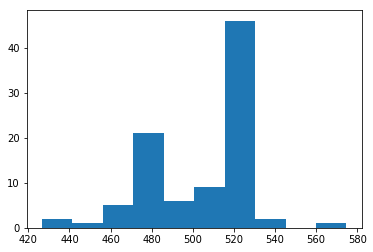

In [13]:
plt.hist([output[f'RO{i}'].loc[0] for i in range(93)])

(array([ 2.,  1.,  5., 21.,  6., 11., 44.,  2.,  0.,  1.]),
 array([426.482 , 441.3086, 456.1352, 470.9618, 485.7884, 500.615 ,
        515.4416, 530.2682, 545.0948, 559.9214, 574.748 ]),
 <a list of 10 Patch objects>)

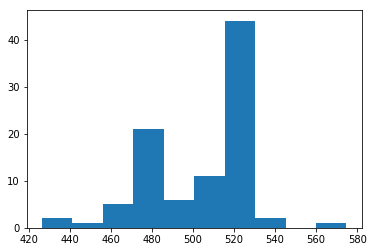

In [15]:
plt.hist([output[f'RO{i}'].loc[0] for i in range(93)])

In [16]:
ol?

In [ ]:
%%time
print(ol.read_RO([0]))

In [ ]:
%%time
print(ol.read_BTI([25]))
#ol.sensor_dict[1]

In [ ]:
%%time
temperature = []
for j in range(7000):
    temperature.append(ol.XADC_temp())
    sleep(0.1)
    if j < 250:
        ol.fix_temperature(55)
    if 500 > j > 250:
        ol.fix_temperature(90)
    if j > 500:
        ol.fix_temperature(120)
ol.top_region_heat_off()

In [ ]:
fig, ax = plt.subplots()
ax.plot(temperature)

ax.set(xlabel='Sample Number', ylabel='Temperature (C)',
       title='Temperature control')
ax.grid()

fig.savefig("Temperature_control2.png", dpi=300)
plt.show()

In [ ]:
%%time
temperature = []
for intensity in range(64):
    ol.top_region_heat_on(intensity)
    for j in range(500):
        temperature.append(ol.XADC_temp())
        sleep(0.1)
ol.top_region_heat_off()


In [ ]:
fig, ax = plt.subplots()
ax.plot(temperature)

ax.set(xlabel='Sample Number', ylabel='Temperature (C)',
       title='Stepwise Temperature Increase')
ax.grid()

fig.savefig("Temperature_curve.png", dpi=300)
plt.show()

In [ ]:
ol.top_region_heat_off()


In [ ]:
max(temperature)

In [17]:
ol = Overlay('/home/xilinx/pynq/overlays/base/base.bit')

In [2]:
ol = Overlay('/home/xilinx/pynq/overlays/RO/RO.bit')

In [13]:
#for item in ol.ip_dict.keys():
a = getattr(ol, 'RO')
a.read(0x00)

496811

In [10]:
ol.RO

In [ ]:
duration = 100
output = ol.record(0.1, duration, f'3stageRO')
fig, axs = plt.subplots(4)
axs[0].plot(output[:,0])
axs[1].plot(output[:,1])
axs[2].plot(output[:,2])
axs[3].plot(output[:,3])

In [ ]:
sleep(20)

In [ ]:
ol = TestChip('/home/xilinx/pynq/overlays/RO/RO3.bit')

In [ ]:
duration = 1000
output = ol.record(0.1, duration, f'RO_A1')
fig, axs = plt.subplots(4)
axs[0].plot(output[:,0])
axs[1].plot(output[:,1])
axs[2].plot(output[:,2])
axs[3].plot(output[:,3])

In [ ]:
sleep(20)

In [ ]:
ol = TestChip('/home/xilinx/pynq/overlays/RO/RO4.bit')

In [ ]:
duration = 1000
output = ol.record(0.1, duration, f'R')
fig, axs = plt.subplots(4)
axs[0].plot(output[:,0])
axs[1].plot(output[:,1])
axs[2].plot(output[:,2])
axs[3].plot(output[:,3])

In [ ]:
for i in range(5):
    ol.top_region_heat_on(i)
    duration = 100
    if i == 4:
        duration = 100
    output = ol.record(0.1, duration, f'5stagetemp')
    print(ol)
ol.top_region_heat_off()

In [ ]:
plt.plot([(np.mean(output[50:100,3]) - np.mean(output[i:i+50,3])) for i in [50,120,220,320,420]])
plt.plot([(np.mean(output[50:100,2]) - np.mean(output[i:i+50,2])) for i in [50,120,220,320,420]])
plt.plot([(np.mean(output[50:100,1]) - np.mean(output[i:i+50,1])) for i in [50,120,220,320,420]])
plt.plot([(np.mean(output[50:100,0]) - np.mean(output[i:i+50,0])) for i in [50,120,220,320,420]])

In [ ]:
print(ol.freq2temp(12.792259999999999))

In [ ]:
np.polyfit([0.0,2.140540000000044,4.881680000000017,8.992880000000042,13.151980000000009, 0.0,2.512080000000026,6.111620000000016,8.735359999999986,11.298200000000008], [0.0, 9.90724291992187,22.632119506835934,37.64801525878907, 50.14895764160157,0.0, 9.90724291992187,22.632119506835934,37.64801525878907, 50.14895764160157], deg = 1)

In [ ]:
for j in range(0,4):
    plt.scatter([(np.mean(output[50:100,j]) - np.mean(output[i:i+50,j])) for i in [50,120,220,320,420]], [( np.mean(output[i:i+50,4])- np.mean(output[50:100,4])) for i in [50,120,220,320,420]])

In [ ]:
[(np.mean(output[50:100,0])-np.mean(output[i:i+50,0])) for i in [50,120,220,320,420]]

In [ ]:
for i in range(32):
    print(f'[{(i+1)*32-1}:{i*32}]')

In [ ]:
np.zeros((5,1)).shape